# Description

This is the same notebook in `nbs/99_manuscript` but adapted for a poster at ISMB 2022.

Creates a plot to summarize predicted cell types and interaction probabilities across the top genes for each correlation coefficients.

# Modules

In [1]:
import pandas as pd
import seaborn as sns

from ccc import conf

# Settings

In [2]:
N_TOP_GENE_PAIRS = 100
N_TOP_TISSUES = 5

# Paths

In [3]:
assert (
    conf.MANUSCRIPT["BASE_DIR"] is not None and conf.MANUSCRIPT["BASE_DIR"].exists()
), "Manuscript dir not set"

In [4]:
COEF_COMP_DIR = conf.MANUSCRIPT["FIGURES_DIR"] / "coefs_comp"
COEF_COMP_DIR.mkdir(parents=True, exist_ok=True)
display(COEF_COMP_DIR)

PosixPath('/opt/manuscript/content/images/coefs_comp')

In [5]:
OUTPUT_FIGURE_DIR = conf.MANUSCRIPT["FIGURES_DIR"] / "ismb2022" / "poster_figures"
OUTPUT_FIGURE_DIR.mkdir(parents=True, exist_ok=True)
display(OUTPUT_FIGURE_DIR)

PosixPath('/opt/manuscript/content/images/ismb2022/poster_figures')

In [6]:
OUTPUT_DIR = conf.GIANT["RESULTS_DIR"] / "intersection_genes"
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
display(OUTPUT_DIR)

PosixPath('/opt/data/results/giant/intersection_genes')

# Summarize

In [7]:
all_subsets_dfs = []

## Functions

In [8]:
def read_hdf(filepath, subset):
    return pd.read_hdf(filepath, key="data").assign(
        order=int(filepath.name.split("-")[0]),
        gene_pair=filepath.name.split("-")[1].split(".")[0].upper(),
        tissue=pd.read_hdf(filepath, key="metadata")["tissue"].squeeze(),
        subset=subset,
    )

## CCC vs Pearson

In [9]:
subset = "clustermatch_vs_pearson"

In [10]:
subset_files = sorted(list((OUTPUT_DIR / subset).glob("*.h5")))
display(len(subset_files))
display(subset_files[:3])

100

[PosixPath('/opt/data/results/giant/intersection_genes/clustermatch_vs_pearson/000-tbcc_ifng.h5'),
 PosixPath('/opt/data/results/giant/intersection_genes/clustermatch_vs_pearson/002-ccl18_zdhhc12.h5'),
 PosixPath('/opt/data/results/giant/intersection_genes/clustermatch_vs_pearson/004-glipr1_ifng.h5')]

In [11]:
_dfs = [read_hdf(f, subset) for f in subset_files]

display(_dfs[0].head())
all_subsets_dfs.extend(_dfs)
display(len(all_subsets_dfs))

,gene1,gene2,weight,order,gene_pair,tissue,subset
0,CLP1,ZNF207,0.282636,0,TBCC_IFNG,nervous-system,clustermatch_vs_pearson
1,CLP1,CXCR6,0.038849,0,TBCC_IFNG,nervous-system,clustermatch_vs_pearson
2,CLP1,RNF113A,0.136710,0,TBCC_IFNG,nervous-system,clustermatch_vs_pearson
3,CLP1,MOAP1,0.085126,0,TBCC_IFNG,nervous-system,clustermatch_vs_pearson
4,CLP1,MRFAP1L1,0.137168,0,TBCC_IFNG,nervous-system,clustermatch_vs_pearson


100

## CCC vs Pearson/Spearman

In [12]:
subset = "clustermatch_vs_pearson_spearman"

In [13]:
subset_files = sorted(list((OUTPUT_DIR / subset).glob("*.h5")))
display(len(subset_files))
display(subset_files[:3])

2

[PosixPath('/opt/data/results/giant/intersection_genes/clustermatch_vs_pearson_spearman/000-dnajc5_gtpbp1.h5'),
 PosixPath('/opt/data/results/giant/intersection_genes/clustermatch_vs_pearson_spearman/004-cyth4_gtpbp1.h5')]

In [14]:
_dfs = [read_hdf(f, subset) for f in subset_files]

display(_dfs[0].head())
all_subsets_dfs.extend(_dfs)
display(len(all_subsets_dfs))

,gene1,gene2,weight,order,gene_pair,tissue,subset
0,NPRL3,NFKBIB,0.108910,0,DNAJC5_GTPBP1,central-nervous-system,clustermatch_vs_pearson_spearman
1,NPRL3,WIZ,0.185644,0,DNAJC5_GTPBP1,central-nervous-system,clustermatch_vs_pearson_spearman
2,NPRL3,ATP6V0C,0.209239,0,DNAJC5_GTPBP1,central-nervous-system,clustermatch_vs_pearson_spearman
3,NPRL3,NECTIN1,0.128082,0,DNAJC5_GTPBP1,central-nervous-system,clustermatch_vs_pearson_spearman
4,NPRL3,MINK1,0.165076,0,DNAJC5_GTPBP1,central-nervous-system,clustermatch_vs_pearson_spearman


102

## CCC vs Spearman

In [15]:
subset = "clustermatch_vs_spearman"

In [16]:
subset_files = sorted(list((OUTPUT_DIR / subset).glob("*.h5")))
display(len(subset_files))
display(subset_files[:3])

24

[PosixPath('/opt/data/results/giant/intersection_genes/clustermatch_vs_spearman/000-kdm6a_uty.h5'),
 PosixPath('/opt/data/results/giant/intersection_genes/clustermatch_vs_spearman/001-cytip_kiaa0040.h5'),
 PosixPath('/opt/data/results/giant/intersection_genes/clustermatch_vs_spearman/002-cytip_rassf2.h5')]

In [17]:
_dfs = [read_hdf(f, subset) for f in subset_files]

display(_dfs[0].head())
all_subsets_dfs.extend(_dfs)
display(len(all_subsets_dfs))

,gene1,gene2,weight,order,gene_pair,tissue,subset
0,WAC,MORC3,0.416091,0,KDM6A_UTY,placenta,clustermatch_vs_spearman
1,WAC,DDX3X,0.357964,0,KDM6A_UTY,placenta,clustermatch_vs_spearman
2,WAC,PHF3,0.421210,0,KDM6A_UTY,placenta,clustermatch_vs_spearman
3,WAC,NIPBL,0.410458,0,KDM6A_UTY,placenta,clustermatch_vs_spearman
4,WAC,ITSN2,0.387687,0,KDM6A_UTY,placenta,clustermatch_vs_spearman


126

## Pearson vs CCC

In [18]:
subset = "pearson_vs_clustermatch"

In [19]:
subset_files = sorted(list((OUTPUT_DIR / subset).glob("*.h5")))
display(len(subset_files))
display(subset_files[:3])

100

[PosixPath('/opt/data/results/giant/intersection_genes/pearson_vs_clustermatch/000-tnni2_myoz1.h5'),
 PosixPath('/opt/data/results/giant/intersection_genes/pearson_vs_clustermatch/001-mybpc2_tnni2.h5'),
 PosixPath('/opt/data/results/giant/intersection_genes/pearson_vs_clustermatch/002-myoz1_pygm.h5')]

In [20]:
_dfs = [read_hdf(f, subset) for f in subset_files]

display(_dfs[0].head())
all_subsets_dfs.extend(_dfs)
display(len(all_subsets_dfs))

,gene1,gene2,weight,order,gene_pair,tissue,subset
0,GVQW3,MYOZ1,0.106883,0,TNNI2_MYOZ1,skeletal-muscle,pearson_vs_clustermatch
1,GVQW3,TNNI2,0.114303,0,TNNI2_MYOZ1,skeletal-muscle,pearson_vs_clustermatch
2,GVQW3,MFSD2B,0.106883,0,TNNI2_MYOZ1,skeletal-muscle,pearson_vs_clustermatch
3,GVQW3,SBK3,0.114303,0,TNNI2_MYOZ1,skeletal-muscle,pearson_vs_clustermatch
4,GVQW3,DCDC2C,0.106883,0,TNNI2_MYOZ1,skeletal-muscle,pearson_vs_clustermatch


226

## Pearson vs CCC/Spearman

In [21]:
subset = "pearson_vs_clustermatch_spearman"

In [22]:
subset_files = sorted(list((OUTPUT_DIR / subset).glob("*.h5")))
display(len(subset_files))
display(subset_files[:3])

100

[PosixPath('/opt/data/results/giant/intersection_genes/pearson_vs_clustermatch_spearman/000-ccl20_scgb3a1.h5'),
 PosixPath('/opt/data/results/giant/intersection_genes/pearson_vs_clustermatch_spearman/001-cxcl1_scgb3a1.h5'),
 PosixPath('/opt/data/results/giant/intersection_genes/pearson_vs_clustermatch_spearman/002-tnni2_tpm2.h5')]

In [23]:
_dfs = [read_hdf(f, subset) for f in subset_files]

display(_dfs[0].head())
all_subsets_dfs.extend(_dfs)
display(len(all_subsets_dfs))

,gene1,gene2,weight,order,gene_pair,tissue,subset
0,NFKBIA,CXCL2,0.921080,0,CCL20_SCGB3A1,mononuclear-phagocyte,pearson_vs_clustermatch_spearman
1,NFKBIA,TNFAIP3,0.988534,0,CCL20_SCGB3A1,mononuclear-phagocyte,pearson_vs_clustermatch_spearman
2,NFKBIA,TRAF1,0.523726,0,CCL20_SCGB3A1,mononuclear-phagocyte,pearson_vs_clustermatch_spearman
3,NFKBIA,IRF1,0.877891,0,CCL20_SCGB3A1,mononuclear-phagocyte,pearson_vs_clustermatch_spearman
4,NFKBIA,BCL2A1,0.960765,0,CCL20_SCGB3A1,mononuclear-phagocyte,pearson_vs_clustermatch_spearman


326

# Combine

In [24]:
df = pd.concat(all_subsets_dfs, ignore_index=True)

In [25]:
df.shape

(34603, 7)

In [26]:
df.head()

,gene1,gene2,weight,order,gene_pair,tissue,subset
0,CLP1,ZNF207,0.282636,0,TBCC_IFNG,nervous-system,clustermatch_vs_pearson
1,CLP1,CXCR6,0.038849,0,TBCC_IFNG,nervous-system,clustermatch_vs_pearson
2,CLP1,RNF113A,0.136710,0,TBCC_IFNG,nervous-system,clustermatch_vs_pearson
3,CLP1,MOAP1,0.085126,0,TBCC_IFNG,nervous-system,clustermatch_vs_pearson
4,CLP1,MRFAP1L1,0.137168,0,TBCC_IFNG,nervous-system,clustermatch_vs_pearson


In [27]:
df["order"].unique()

array([  0,   2,   4,   6,   7,   8,  10,  11,  12,  13,  14,  15,  16,
        17,  18,  22,  23,  24,  25,  26,  28,  29,  30,  31,  32,  33,
        35,  36,  37,  39,  41,  42,  43,  44,  46,  47,  50,  52,  55,
        56,  57,  58,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,
        70,  71,  72,  73,  75,  78,  79,  80,  81,  82,  83,  84,  85,
        88,  89,  90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100,
       101, 103, 104, 105, 106, 107, 108, 109, 110, 111, 113, 114, 115,
       116, 117, 120, 121, 122, 123, 125, 126, 127,   1,   5,   9,  20,
        21,  27,   3,  19,  34,  38,  40,  45,  48,  49,  51,  53,  54,
        59,  74,  76,  77,  86,  87])

# Stats

In [28]:
df_stats = df.groupby(["subset"])["gene_pair"].nunique()
display(df_stats)

subset
clustermatch_vs_pearson             100
clustermatch_vs_pearson_spearman      2
clustermatch_vs_spearman             24
pearson_vs_clustermatch             100
pearson_vs_clustermatch_spearman    100
Name: gene_pair, dtype: int64

In [29]:
assert df_stats["clustermatch_vs_pearson"] == N_TOP_GENE_PAIRS
assert df_stats["pearson_vs_clustermatch"] == N_TOP_GENE_PAIRS
assert df_stats["pearson_vs_clustermatch_spearman"] == N_TOP_GENE_PAIRS

# Combine subsets

In [30]:
subset_cm_vs_rest = "clustermatch_vs_rest"
subset_p_vs_rest = "pearson_vs_rest"

In [31]:
df = df.replace(
    {
        "subset": {
            "clustermatch_vs_pearson": subset_cm_vs_rest,
            "clustermatch_vs_spearman": subset_cm_vs_rest,
            "clustermatch_vs_pearson_spearman": subset_cm_vs_rest,
            "pearson_vs_clustermatch": subset_p_vs_rest,
            "pearson_vs_clustermatch_spearman": subset_p_vs_rest,
        },
    }
)

In [32]:
df.head()

,gene1,gene2,weight,order,gene_pair,tissue,subset
0,CLP1,ZNF207,0.282636,0,TBCC_IFNG,nervous-system,clustermatch_vs_rest
1,CLP1,CXCR6,0.038849,0,TBCC_IFNG,nervous-system,clustermatch_vs_rest
2,CLP1,RNF113A,0.136710,0,TBCC_IFNG,nervous-system,clustermatch_vs_rest
3,CLP1,MOAP1,0.085126,0,TBCC_IFNG,nervous-system,clustermatch_vs_rest
4,CLP1,MRFAP1L1,0.137168,0,TBCC_IFNG,nervous-system,clustermatch_vs_rest


In [33]:
assert df["subset"].unique().shape[0] == 2

# Analyses

Here we read the gene pair queries sent to GIANT to see 1) which cell type were predicted for each of them and 2) the characteristics of the predicted networks for each gene pair.

This allows us to assess whether gene pairs found by our correlation coefficients in GTEx (whole blood) replicate in GIANT by seeing if the predicted cell types is a blood cell lineage (leukocyte, etc) and the network connectivity is high.

In [34]:
# for each subset (ccc vs etc, pearson vs etc), sort by top gene pairs
# for that, for each subset, sort by "order", which indicates, for each subset
# the gene pairs with the largest correlation value
top_gene_pairs = df.groupby(["subset"], group_keys=False).apply(
    lambda x: x.sort_values(["order", "gene_pair"], ascending=True)[
        "gene_pair"
    ].unique()
)

In [35]:
top_gene_pairs

subset
clustermatch_vs_rest    [DNAJC5_GTPBP1, KDM6A_UTY, TBCC_IFNG, CYTIP_KI...
pearson_vs_rest         [CCL20_SCGB3A1, TNNI2_MYOZ1, CXCL1_SCGB3A1, MY...
dtype: object

In [36]:
# now use the order of gene pairs within subsets to actually select the top ones
top_df = df.groupby(["subset"], group_keys=False).apply(
    lambda x: x[x["gene_pair"].isin(top_gene_pairs.loc[x.name][:N_TOP_GENE_PAIRS])]
)

In [37]:
top_df.shape

(21620, 7)

In [38]:
top_df.head()

,gene1,gene2,weight,order,gene_pair,tissue,subset
0,CLP1,ZNF207,0.282636,0,TBCC_IFNG,nervous-system,clustermatch_vs_rest
1,CLP1,CXCR6,0.038849,0,TBCC_IFNG,nervous-system,clustermatch_vs_rest
2,CLP1,RNF113A,0.136710,0,TBCC_IFNG,nervous-system,clustermatch_vs_rest
3,CLP1,MOAP1,0.085126,0,TBCC_IFNG,nervous-system,clustermatch_vs_rest
4,CLP1,MRFAP1L1,0.137168,0,TBCC_IFNG,nervous-system,clustermatch_vs_rest


In [39]:
plot_stats = top_df.groupby(["subset", "tissue"])["gene_pair"].nunique()

In [40]:
plot_stats.head()

subset                tissue                
clustermatch_vs_rest  b-lymphocyte               3
                      blood                     16
                      brain                      2
                      central-nervous-system     6
                      diencephalon               1
Name: gene_pair, dtype: int64

In [41]:
plot_stats = (
    plot_stats.groupby("subset")
    .apply(lambda grp: grp.nlargest(N_TOP_TISSUES))
    .droplevel(0)
).rename("n_gene_pairs")

# by percentage
# plot_stats = plot_stats.groupby("subset").apply(lambda x: x / x.sum())

In [42]:
plot_stats

subset                tissue               
clustermatch_vs_rest  blood                    16
                      mononuclear-phagocyte    14
                      natural-killer-cell      13
                      leukocyte                 9
                      macrophage                8
pearson_vs_rest       skeletal-muscle          36
                      liver                    18
                      placenta                 12
                      blood                     9
                      mononuclear-phagocyte     7
Name: n_gene_pairs, dtype: int64

In [43]:
# sum gene pairs, it should be less than 100 (100 is the total number of gene pairs taken)
tmp = plot_stats.groupby("subset").sum()
display(tmp)
assert (tmp < N_TOP_GENE_PAIRS).all()

subset
clustermatch_vs_rest    60
pearson_vs_rest         82
Name: n_gene_pairs, dtype: int64

In [44]:
plot_stats.index.get_level_values("tissue").unique().shape

(8,)

In [45]:
plot_stats = plot_stats.reset_index()
display(plot_stats.head())

,subset,tissue,n_gene_pairs
0,clustermatch_vs_rest,blood,16
1,clustermatch_vs_rest,mononuclear-phagocyte,14
2,clustermatch_vs_rest,natural-killer-cell,13
3,clustermatch_vs_rest,leukocyte,9
4,clustermatch_vs_rest,macrophage,8


In [46]:
plot_stats["subset"].unique()

array(['clustermatch_vs_rest', 'pearson_vs_rest'], dtype=object)

In [47]:
plot_stats["tissue"].unique()

array(['blood', 'mononuclear-phagocyte', 'natural-killer-cell',
       'leukocyte', 'macrophage', 'skeletal-muscle', 'liver', 'placenta'],
      dtype=object)

# Plots

In [48]:
PREDICTED_TISSUE_LABEL = "Predicted tissue/cell type\nin GIANT"
N_GENE_PAIRS_LABEL = "Number of gene pairs"
AVG_PROB_INTERACTION_LABEL = (
    "Average probability of interaction\nin tissue-specific networks"
)

In [49]:
subset_renames = {
    "clustermatch_vs_rest": "CCC vs others",
    # "clustermatch_vs_pearson_spearman": "CCC vs Pearson/Spearman",
    # "clustermatch_vs_spearman": "CCC vs Spearman",
    "pearson_vs_rest": "Pearson vs others",
    # "pearson_vs_clustermatch_spearman": "Pearson vs CCC/Spearman",
}

tissue_renames = {
    "blood": "Blood",
    "mononuclear-phagocyte": "Mononuclear phagocyte",
    "natural-killer-cell": "Natural killer cell",
    "leukocyte": "Leukocyte",
    "macrophage": "Macrophage",
    "granulocyte": "Granulocyte",
    "skeletal-muscle": "Skeletal muscle",
    "liver": "Liver",
    "placenta": "Placenta",
}

## First plot version

These first plot versions are drafts, just to see how the pattern are.
The final plots are generated in the `Second plot version` below.

In [50]:
count_data = plot_stats.replace(
    {
        "subset": subset_renames,
        "tissue": tissue_renames,
    }
)

### Tissues order

In [51]:
blood_related_tissues = set(
    [
        "Blood",
        "Mononuclear phagocyte",
        "Natural killer cell",
        "Leukocyte",
        "Macrophage",
    ]
)

In [52]:
tissues_order = [
    "Blood",
    "Mononuclear phagocyte",
    "Natural killer cell",
    "Leukocyte",
    "Macrophage",
    "Skeletal muscle",
    "Liver",
    "Placenta",
]

### Tissues colors

In [53]:
deep_colors = sns.color_palette("tab10")
display(deep_colors)

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

In [54]:
blood_color = deep_colors[3]
others_color = deep_colors[0]

In [55]:
tissue_colors = {
    t: blood_color if t in blood_related_tissues else others_color
    for t in tissues_order
}

### Plot: number of gene pairs by tissue and method

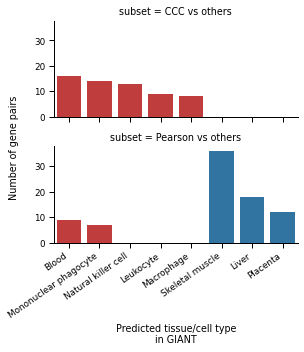

In [56]:
with sns.plotting_context("paper", font_scale=1.0):
    g = sns.FacetGrid(
        count_data,
        row="subset",
        sharex=True,
        sharey=True,
        height=2.0,
        aspect=2.1,
    )
    g.map(
        sns.barplot,
        "tissue",
        "n_gene_pairs",
        order=tissues_order,
        palette=tissue_colors,
    )
    g.set_xticklabels(rotation=35, ha="right")
    g.set_axis_labels(PREDICTED_TISSUE_LABEL, "")

    g.fig.text(0, 0.30, N_GENE_PAIRS_LABEL, rotation=90)

### Plot: gene networks connectivity by tissue and method

In [57]:
conn_data = pd.merge(
    top_df,
    plot_stats,
    left_on=["subset", "tissue"],
    right_on=["subset", "tissue"],
    how="inner",
)

In [58]:
conn_data = conn_data.replace(
    {
        "subset": subset_renames,
        "tissue": tissue_renames,
    }
)

In [59]:
conn_data.shape

(15138, 8)

In [60]:
conn_data.head()

,gene1,gene2,weight,order,gene_pair,tissue,subset,n_gene_pairs
0,CCL3,SCAMP2,0.111008,2,CCL18_ZDHHC12,Macrophage,CCC vs others,8
1,CCL3,CCL5,0.500257,2,CCL18_ZDHHC12,Macrophage,CCC vs others,8
2,CCL3,HLA-DMB,0.788821,2,CCL18_ZDHHC12,Macrophage,CCC vs others,8
3,CCL3,GBP1,0.127745,2,CCL18_ZDHHC12,Macrophage,CCC vs others,8
4,CCL3,ZDHHC12,0.031800,2,CCL18_ZDHHC12,Macrophage,CCC vs others,8


In [61]:
# # only keep connections with query genes
# conn_data = conn_data.assign(query_genes=conn_data["gene_pair"].apply(lambda x: set(x.split("_"))))

In [62]:
# conn_data = conn_data[conn_data.apply(
#     lambda x:
#         (x["gene1"] in x["query_genes"]) | (x["gene2"] in x["query_genes"]),
#     axis=1
# )]

In [63]:
# conn_data.shape

In [64]:
# conn_data.head()

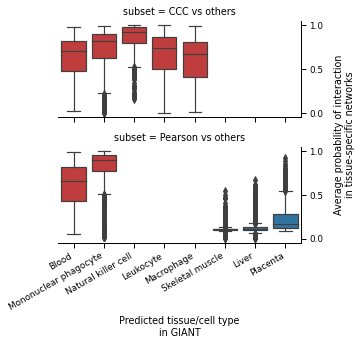

In [65]:
with sns.plotting_context("paper", font_scale=1.0):
    g = sns.FacetGrid(
        conn_data,
        row="subset",
        sharex=True,
        sharey=True,
        height=2.0,
        aspect=2.1,
    )
    g.map(sns.boxplot, "tissue", "weight", order=tissues_order, palette=tissue_colors)
    g.set_xticklabels(rotation=30, ha="right")
    g.set_axis_labels(PREDICTED_TISSUE_LABEL, "")

    for ax in g.axes:
        ax = ax[0]
        sns.despine(ax=ax, left=True, right=False)
        ax.yaxis.tick_right()
        ax.yaxis.set_label_position("right")

    g.fig.text(1.10, 0.25, AVG_PROB_INTERACTION_LABEL, rotation=90, ha="center")

## Second plot version

### Tissues order

In [66]:
ccc_tissues = {
    "Natural killer cell",
    "Leukocyte",
    "Macrophage",
}

pcc_tissues = {
    "Skeletal muscle",
    "Liver",
    "Placenta",
}

shared_tissues = {
    "Blood",
    "Mononuclear phagocyte",
}

# make sure I'm not missing a tissue
assert set(tissues_order) == (ccc_tissues | pcc_tissues | shared_tissues)

# new tissues_order
tissues_order = [
    "Macrophage",
    "Leukocyte",
    "Natural killer cell",
    "Blood",
    "Mononuclear phagocyte",
    "Skeletal muscle",
    "Liver",
    "Placenta",
]

assert set(tissues_order) == (ccc_tissues | pcc_tissues | shared_tissues)

### Tissues colors

In [67]:
display(deep_colors)

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

In [68]:
# by specific or shared
ccc_color = deep_colors[3]
shared_color = deep_colors[4]
pcc_color = deep_colors[0]

In [69]:
tissue_colors = {
    t: ccc_color
    if t in ccc_tissues
    else pcc_color
    if t in pcc_tissues
    else shared_color
    for t in tissues_order
}

### Plot: number of gene pairs by tissue and method

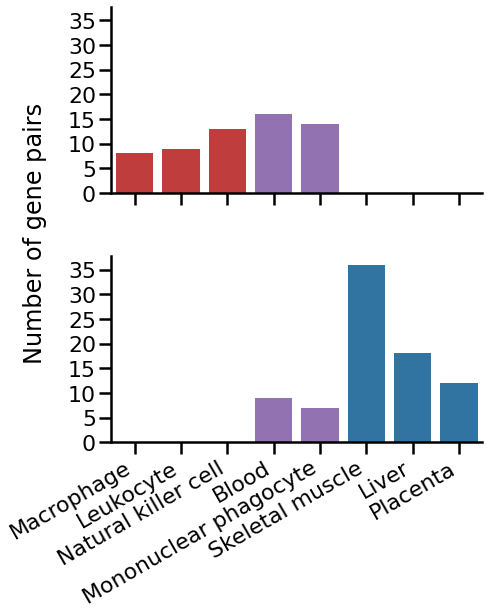

In [78]:
with sns.plotting_context("poster", font_scale=1.0):
    g = sns.FacetGrid(
        count_data,
        row="subset",
        sharex=True,
        sharey=True,
        height=4.0,
        aspect=1.8,
    )
    g.map(
        sns.barplot,
        "tissue",
        "n_gene_pairs",
        order=tissues_order,
        palette=tissue_colors,
    )
    g.set_xticklabels(rotation=30, ha="right")
    # g.set_axis_labels(PREDICTED_TISSUE_LABEL, "")
    g.set_axis_labels("", "")

    g.set_titles(row_template="")

    g.fig.text(0.02, 0.30, N_GENE_PAIRS_LABEL, rotation=90)

    g.savefig(
        OUTPUT_FIGURE_DIR / "top_gene_pairs-tissue_count.svg",
        bbox_inches="tight",
        dpi=300,
        # facecolor="white",
        transparent=True,
    )

### Plot: gene networks connectivity by tissue and method

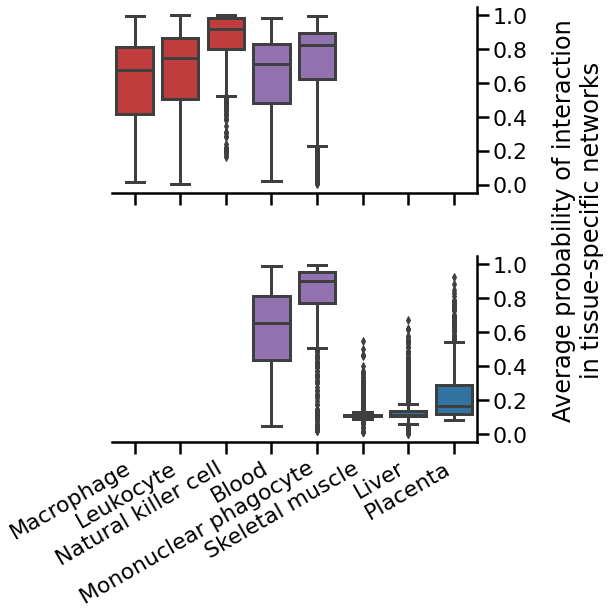

In [79]:
with sns.plotting_context("poster", font_scale=1.0):
    g = sns.FacetGrid(
        conn_data,
        row="subset",
        sharex=True,
        sharey=True,
        height=4.0,
        aspect=1.8,
    )
    g.map(sns.boxplot, "tissue", "weight", order=tissues_order, palette=tissue_colors)
    g.set_xticklabels(rotation=30, ha="right")
    # g.set_axis_labels(PREDICTED_TISSUE_LABEL, "")
    g.set_axis_labels("", "")

    g.set_titles(row_template="")

    for ax in g.axes:
        ax = ax[0]
        sns.despine(ax=ax, left=True, right=False)
        ax.yaxis.tick_right()
        ax.yaxis.set_label_position("right")

    g.fig.text(1.10, 0.20, AVG_PROB_INTERACTION_LABEL, rotation=90, ha="center")

    g.savefig(
        OUTPUT_FIGURE_DIR / "top_gene_pairs-tissue_avg_weight.svg",
        bbox_inches="tight",
        dpi=300,
        # facecolor="white",
        transparent=True,
    )

# Raw numbers

In [80]:
count_data.sort_values(["subset", "n_gene_pairs"], ascending=[True, False])

,subset,tissue,n_gene_pairs
0,CCC vs others,Blood,16
1,CCC vs others,Mononuclear phagocyte,14
2,CCC vs others,Natural killer cell,13
3,CCC vs others,Leukocyte,9
4,CCC vs others,Macrophage,8
5,Pearson vs others,Skeletal muscle,36
6,Pearson vs others,Liver,18
7,Pearson vs others,Placenta,12
8,Pearson vs others,Blood,9
9,Pearson vs others,Mononuclear phagocyte,7


In [81]:
conn_data.groupby(["subset", "tissue"])["weight"].describe()

count      mean       std       min  \
subset            tissue                                                        
CCC vs others     Blood                  1999.0  0.635626  0.241190  0.023335   
                  Leukocyte              1146.0  0.653154  0.266569  0.001895   
                  Macrophage             1015.0  0.605884  0.265471  0.015116   
                  Mononuclear phagocyte  1810.0  0.715005  0.263198  0.005849   
                  Natural killer cell    1478.0  0.863648  0.153513  0.164965   
Pearson vs others Blood                  1098.0  0.605613  0.249599  0.048062   
                  Liver                  1604.0  0.146128  0.093899  0.002845   
                  Mononuclear phagocyte   910.0  0.807049  0.234952  0.016067   
                  Placenta               1023.0  0.239777  0.169568  0.084798   
                  Skeletal muscle        3055.0  0.113124  0.029374  0.011840   

                                              25%       50%       75%  \
subset            tissue                                                
CCC vs others     Blood                  0.483138  0.710755  0.827111   
                  Leukocyte              0.504050  0.744179  0.864689   
                  Macrophage             0.416022  0.676276  0.808777   
                  Mononuclear phagocyte  0.624547  0.822325  0.896281   
                  Natural killer cell    0.797427  0.920069  0.981648   
Pearson vs others Blood                  0.433474  0.656539  0.814353   
                  Liver                  0.103968  0.112115  0.133753   
                  Mononuclear phagocyte  0.773291  0.899533  0.954558   
                  Placenta               0.116744  0.167764  0.286761   
                  Skeletal muscle        0.104272  0.107967  0.114303   

                                              max  
subset            tissue                           
CCC vs others     Blood                  0.981239  
                  Leukocyte              0.998099  
                  Macrophage             0.993414  
                  Mononuclear phagocyte  0.994341  
                  Natural killer cell    0.999793  
Pearson vs others Blood                  0.988633  
                  Liver                  0.669685  
                  Mononuclear phagocyte  0.994341  
                  Placenta               0.922224  
                  Skeletal muscle        0.547389

# Create final figure

In [82]:
from svgutils.compose import Figure, SVG, Panel, Text

In [83]:
BLOOD_NETWORKS_DIR = OUTPUT_FIGURE_DIR / "blood_tissues" / "gene_pair_networks"
AUTO_SELECTED_NETWORKS_DIR = (
    OUTPUT_FIGURE_DIR / "auto_selected_tissues" / "gene_pair_networks"
)

In [87]:
Figure(
    "52.522cm",
    "30.827cm",
    # white background
    # Panel(
    #     SVG(COEF_COMP_DIR / "white_background.svg"),
    # )
    # .scale(0.5)
    # .move(0, 0),
    Panel(
        SVG(OUTPUT_FIGURE_DIR / "top_gene_pairs-tissue_count.svg").scale(0.5),
        # cm vs rest
        SVG(COEF_COMP_DIR / "triangles-c_vs_p.svg").scale(3.50).move(70, 4),
        Text("+", 70 + 45, 17, size=15),
        SVG(COEF_COMP_DIR / "triangles-c_vs_ps.svg").scale(3.50).move(70 + 45 + 15, 4),
        Text("+", 70 + 45 + 15 + 52, 17, size=15),
        SVG(COEF_COMP_DIR / "triangles-c_vs_s.svg")
        .scale(3.50)
        .move(70 + 45 + 15 + 55 + 15, 4),
        # p vs rest
        SVG(COEF_COMP_DIR / "triangles-p_vs_c.svg").scale(3.50).move(70, 128),
        Text("+", 70 + 45, 142, size=15),
        SVG(COEF_COMP_DIR / "triangles-p_vs_cs.svg")
        .scale(3.50)
        .move(70 + 45 + 15, 128),
        # another
        SVG(OUTPUT_FIGURE_DIR / "top_gene_pairs-tissue_avg_weight.svg")
        .scale(0.5)
        .move(220, 0),
        # Text("c)", 0, 9, size=6, weight="bold"),
    ).scale(0.10),
).save(OUTPUT_FIGURE_DIR / "giant.svg")

Compile the manuscript with manubot and make sure the image has a white background and displays properly.